In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score


In [4]:
df = pd.read_csv("data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [6]:
df["Fuel_Efficiency"] = (df["city mpg"] + df["highway MPG"]) / 2

In [7]:
df.drop(["Make", "Model", "Market Category"], axis=1, inplace=True)

In [8]:
df["Engine Fuel Type"].fillna(df["Engine Fuel Type"].mode()[0], inplace=True)
df["Engine HP"].fillna(df["Engine HP"].median(), inplace=True)
df["Engine Cylinders"].fillna(df["Engine Cylinders"].median(), inplace=True)
df["Number of Doors"].fillna(df["Number of Doors"].median(), inplace=True)

C:\Users\jishn\AppData\Local\Temp\ipykernel_14248\389662626.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Engine Fuel Type"].fillna(df["Engine Fuel Type"].mode()[0], inplace=True)
C:\Users\jishn\AppData\Local\Temp\ipykernel_14248\389662626.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

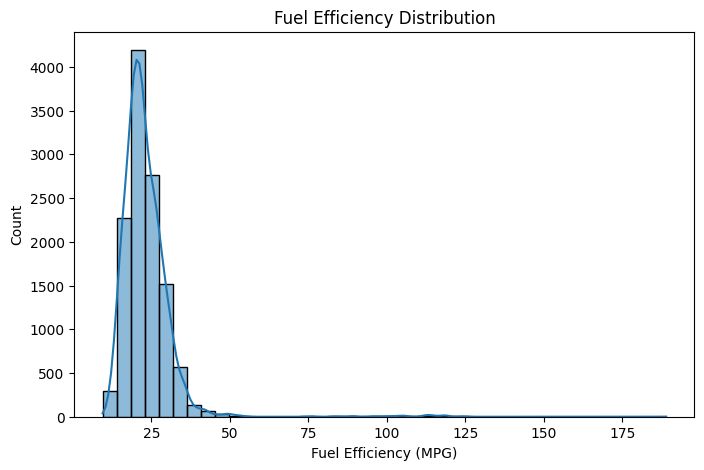

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df["Fuel_Efficiency"], bins=40, kde=True)

plt.title("Fuel Efficiency Distribution")
plt.xlabel("Fuel Efficiency (MPG)")
plt.ylabel("Count")
plt.show()

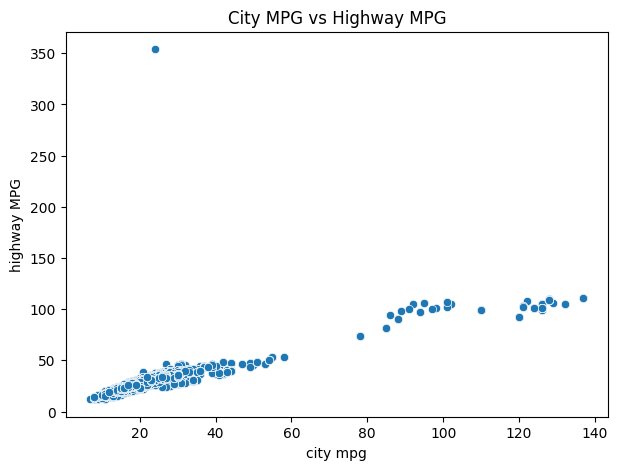

In [10]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=df["city mpg"],
    y=df["highway MPG"]
)

plt.title("City MPG vs Highway MPG")
plt.show()

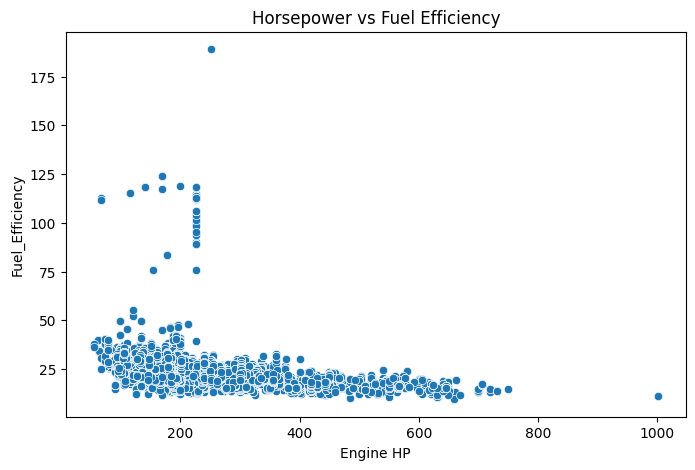

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=df["Engine HP"],
    y=df["Fuel_Efficiency"]
)

plt.title("Horsepower vs Fuel Efficiency")
plt.show()

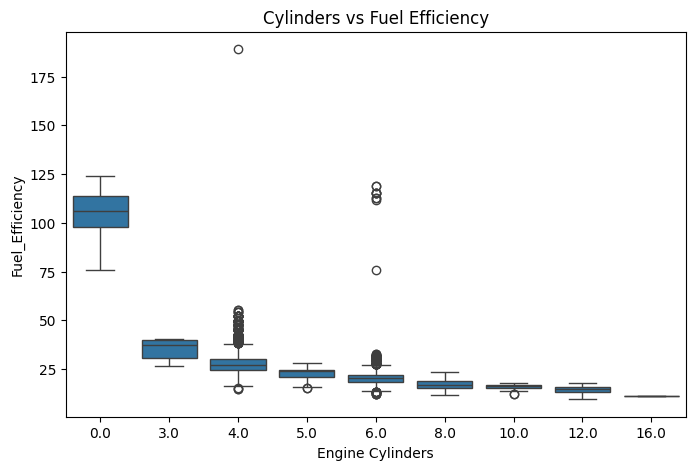

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x=df["Engine Cylinders"],
    y=df["Fuel_Efficiency"]
)

plt.title("Cylinders vs Fuel Efficiency")
plt.show()

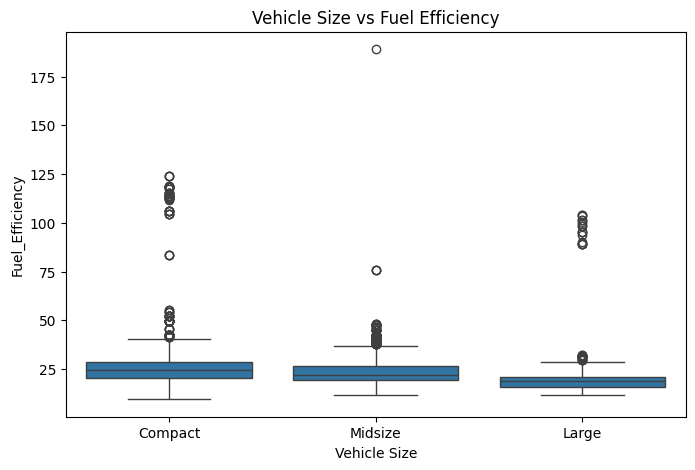

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x=df["Vehicle Size"],
    y=df["Fuel_Efficiency"]
)

plt.title("Vehicle Size vs Fuel Efficiency")
plt.show()

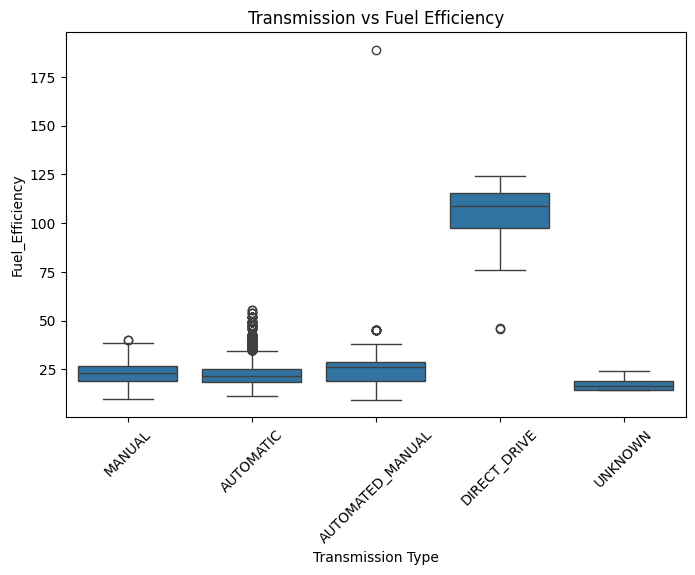

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x=df["Transmission Type"],
    y=df["Fuel_Efficiency"]
)

plt.xticks(rotation=45)
plt.title("Transmission vs Fuel Efficiency")
plt.show()

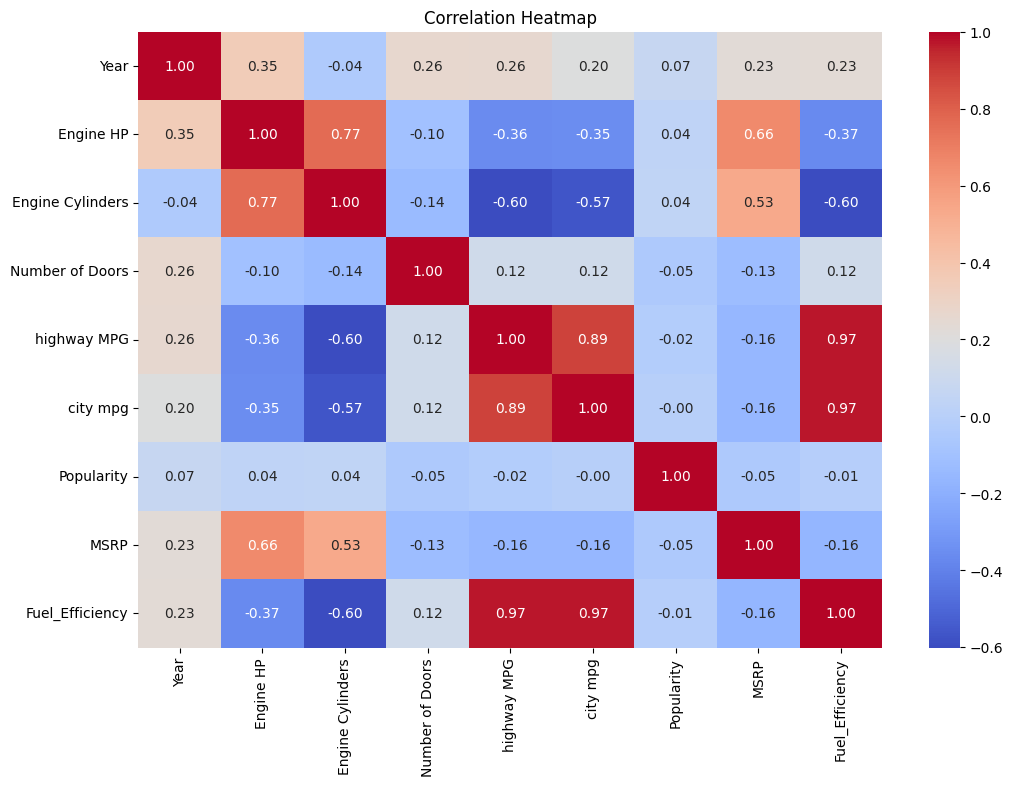

In [15]:
plt.figure(figsize=(12,8))

corr = df.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation Heatmap")
plt.show()


In [16]:
df.drop(["city mpg", "highway MPG"], axis=1, inplace=True)

In [17]:
df = pd.get_dummies(df, drop_first=True)

In [18]:
X = df.drop("Fuel_Efficiency", axis=1)
y = df["Fuel_Efficiency"]

In [19]:
import joblib

joblib.dump(X.columns.tolist(), "training_columns.pkl")

['training_columns.pkl']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
import joblib

joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [22]:
def build_ann_model(
    neurons1=64,
    neurons2=32,
    dropout_rate=0.2,
    learning_rate=0.001
):
    
    model = Sequential()
    
    # Input + Hidden 1
    model.add(Dense(neurons1, activation='relu',
                    input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    
    # Hidden 2
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Output
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model


In [23]:
ann_regressor = KerasRegressor(
    model=build_ann_model,
    verbose=0
)


In [24]:
param_dist = {

    "model__neurons1": [32, 64, 128],
    "model__neurons2": [16, 32, 64],
    "model__dropout_rate": [0.1, 0.2, 0.3],
    "model__learning_rate": [0.01, 0.001, 0.0001],

    "batch_size": [16, 32, 64],
    "epochs": [50, 80, 100]

}


In [25]:
random_search = RandomizedSearchCV(

    estimator=ann_regressor,
    param_distributions=param_dist,
    n_iter=10,          # increase for deeper search
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\jishn\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",KerasRegresso...se epochs=1 )
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'batch_size': [16, 32, ...], 'epochs': [50, 80, ...], 'model__dropout_rate': [0.1, 0.2, ...], 'model__learning_rate': [0.01, 0.001, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used

In [26]:
print("Best Parameters:\n")
print(random_search.best_params_)


Best Parameters:

{'model__neurons2': 32, 'model__neurons1': 128, 'model__learning_rate': 0.0001, 'model__dropout_rate': 0.2, 'epochs': 80, 'batch_size': 16}


In [27]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 2.451770551132136
R2 Score: 0.9386009494100503


In [ ]:
best_model.model_.save("fuel_efficiency_tuned_ann.keras")
